# MULTIPLE LINEAR REGRESSION - MLR (SQRT Transformed)

In [21]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

## BASELINE MODEL: 

- “Country”, “Jobtype”, “Education”, “Job title”, “Company size”, “Age”, “Experience” and “Annual Salary” 


In [22]:
df = pd.read_csv('clean_and_encoded_df.csv')

# Apply sqrt transformation to the Annual_salary column
df['Annual_salary'] = np.sqrt(df['Annual_salary'])

# Create a list of columns to keep
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep = [col for col in df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_df = df[columns_to_keep]


baseline_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Andorra,Country_Angola,Country_Argentina,...,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,4.8,200.511845
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,6.4,229.715041
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.0,232.432786
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,7.8,268.780580
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,11.4,250.639183


Baseline model:

In [23]:
base_X = baseline_df.drop('Annual_salary', axis=1)
y = baseline_df['Annual_salary']
print(base_X.shape)
print(y.shape)

(2805, 138)
(2805,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(base_X, y, test_size=0.2, random_state=42)
y_train = y_train.reset_index(drop=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Code with Adj R2

k = 5
num_val_samples = len(X_train_scaled) // k
all_scores_r2 = []
all_scores_adjusted_r2 = []
all_scores_rmse = []
all_scores_mae = []


for i in range(k):
    print('processing fold #', i)
    val_data = X_train_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [X_train_scaled[:i * num_val_samples],
         X_train_scaled[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    model = LinearRegression()
    model.fit(partial_train_data, partial_train_targets)

    val_preds = model.predict(val_data)
    # Reverse sqrt transformation
    val_preds_sqrd = val_preds**2 
    val_targets_sqrd = val_targets**2 

    r2_val = r2_score(val_targets_sqrd, val_preds_sqrd)
    n = val_data.shape[0]
    p = val_data.shape[1]
    adjusted_r2_val = 1 - (1 - r2_val) * (n - 1) / (n - p - 1)
    rmse_val = np.sqrt(mean_squared_error(val_targets_sqrd, val_preds_sqrd))
    mae_val = mean_absolute_error(val_targets_sqrd, val_preds_sqrd)

    all_scores_r2.append(r2_val)
    all_scores_adjusted_r2.append(adjusted_r2_val)
    all_scores_rmse.append(rmse_val)
    all_scores_mae.append(mae_val)


mean_r2 = np.mean(all_scores_r2)
std_r2 = np.std(all_scores_r2)
mean_adjusted_r2 = np.mean(all_scores_adjusted_r2)
std_adjusted_r2 = np.std(all_scores_adjusted_r2)
mean_rmse = np.mean(all_scores_rmse)
std_rmse = np.std(all_scores_rmse)
mean_mae = np.mean(all_scores_mae)
std_mae = np.std(all_scores_mae)

print(f"Rendimiento promedio R2 (XGBoost): {mean_r2:.3f} (+/- {std_r2:.3f})")
print(f"Rendimiento promedio R2 ajustado (XGBoost): {mean_adjusted_r2:.3f} (+/- {std_adjusted_r2:.3f})")
print(f"Rendimiento promedio RMSE (XGBoost): {mean_rmse:.3f} (+/- {std_rmse:.3f})")
print(f"Rendimiento promedio MAE (XGBoost): {mean_mae:.3f} (+/- {std_mae:.3f})")


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
Rendimiento promedio R2 (XGBoost): -1194797015950996506640097695470305348169392302172634349568.000 (+/- 1331275468480090441441589374162572794039819921364176863232.000)
Rendimiento promedio R2 ajustado (XGBoost): -1728395683268917455894943438429590154966079102530552332288.000 (+/- 1925825677704208184665799091343403953216960731368751366144.000)
Rendimiento promedio RMSE (XGBoost): 1511754988842931293061336459640832.000 (+/- 950809572617345086675908061822976.000)
Rendimiento promedio MAE (XGBoost): 110409360693827807013901116112896.000 (+/- 66113638044535308398772776599552.000)


In [26]:
mlr_results_dic = {}

mlr_results_dic['MLR'] = {'R2': mean_r2, 'Adj R2': mean_adjusted_r2, 'RMSE': mean_rmse, 'MAE': mean_mae }
mlr_results = pd.DataFrame.from_dict(mlr_results_dic, orient='index')
mlr_results

,R2,Adj R2,RMSE,MAE
MLR,-1.194797e+57,-1.728396e+57,1.511755e+33,1.104094e+32


In [27]:
mlr_results.to_csv('sqrt_mlr_results.csv', index=True)

In [28]:
# Combine the training and validation sets
X_train_val = np.concatenate((X_train_scaled, val_data), axis=0)
y_train_val = np.concatenate((y_train, val_targets), axis=0)

# Train the model on the combined training and validation sets
model.fit(X_train_val, y_train_val)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Reverse sqrt transformation
y_pred_sqrd = y_pred**2 #np.exp(y_pred)
y_test_sqrd = y_test**2 #np.exp(y_test)

# Calculate the R2 score, Adjusted R2, RMSE, and MAE
r2_test = r2_score(y_test_sqrd, y_pred_sqrd)
rmse_test = np.sqrt(mean_squared_error(y_test_sqrd, y_pred_sqrd))
mae_test = mean_absolute_error(y_test_sqrd, y_pred_sqrd)
n_test = len(X_test_scaled)
p_test = X_train_val.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

print(f"R2 in validation set (MLR): {r2_test:.3f}")
print(f"Adjusted R2 in validation set (MLR): {adjusted_r2_test:.3f}")
print(f"RMSE in validation set (MLR): {rmse_test:.3f}")
print(f"MAE  in validation set (MLR): {mae_test:.3f}")


R2 in validation set (MLR): -84740684383885797662253178261308230851261951377408.000
Adjusted R2 in validation set (MLR): -112452093021270247112881605370077226631650227519488.000
RMSE in validation set (MLR): 466783670581383462079145443328.000
MAE  in validation set (MLR): 42260014648380955595653513216.000


In [29]:
test_results_dic = {}
test_results_dic['MLR'] = {'R2': r2_test,  'Adj R2': adjusted_r2_test, 'RMSE': rmse_test, 'MAE': mae_test}
test_results = pd.DataFrame.from_dict(test_results_dic, orient='index')
test_results

,R2,Adj R2,RMSE,MAE
MLR,-8.474068e+49,-1.124521e+50,4.667837e+29,4.226001e+28


In [30]:
test_results.to_csv('sqrt_test_mlr_results.csv', index=True)

ValueError: Maximum allowed size exceeded

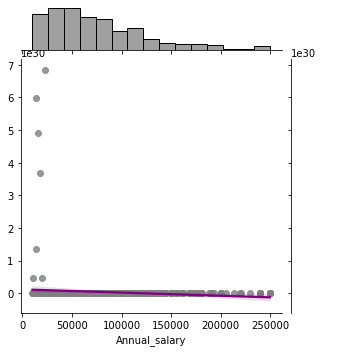

In [31]:
# Create a joint dataframe by concatenating the two variables
g = sns.JointGrid(x=y_test_sqrd, y=y_pred_sqrd, height=5)

# Create scatterplot and regression plots
g.plot_joint(sns.regplot, scatter_kws={'color': 'grey'}, line_kws={'color': 'purple'})

# Add histograms
g.plot_marginals(sns.histplot, kde=False, color='grey')

# Adjust the arrangement of the plots
g.fig.subplots_adjust(top=0.9)

# Add a title
g.fig.suptitle("MLR performance - Test set")

# Set x and y axis labels
g.ax_joint.set_xlabel("Truth")
g.ax_joint.set_ylabel("Predictions")

plt.show()